#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [2]:
# !pip install pandas_profiling
# !pip install treeinterpreter
# !pip install waterfallcharts
# !pip install optuna
# !pip install shap

In [60]:
import pandas_profiling

import scipy as ss
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import plot_partial_dependence

from lightgbm import LGBMRegressor 


from catboost import cv, Pool, CatBoostRegressor

from treeinterpreter import treeinterpreter as ti
from scipy.cluster import hierarchy as hc

import scipy.stats

import optuna
from optuna import Trial

import shap

## Подготовка

In [82]:
df = pd.read_csv('C:/Users/nikit/Yandex/projects/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [83]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Имеется смещение в распределении

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В данных нет пропусков, имеется 537 строк, где заказов 0, нужно будет глянуть.

In [86]:
df.sort_index(inplace=True)

In [87]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Пока что ничего нельзя сказать, кроме того, что данные хорошие и что распределение слегка скошено.

## Анализ

In [88]:
df_resample = df.resample('1H').sum()

In [89]:
decomposed = seasonal_decompose(df_resample) 

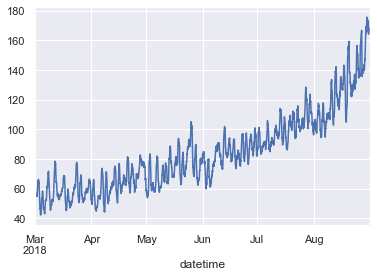

In [90]:
decomposed.trend.plot();

С каждым месяцем люди все больше и больше пользуются такси. Также можно заметить, что в июне происходит торможение, т.е. рост не наблюдается. До мая рост также не наблюдается, в мае начинается рост.

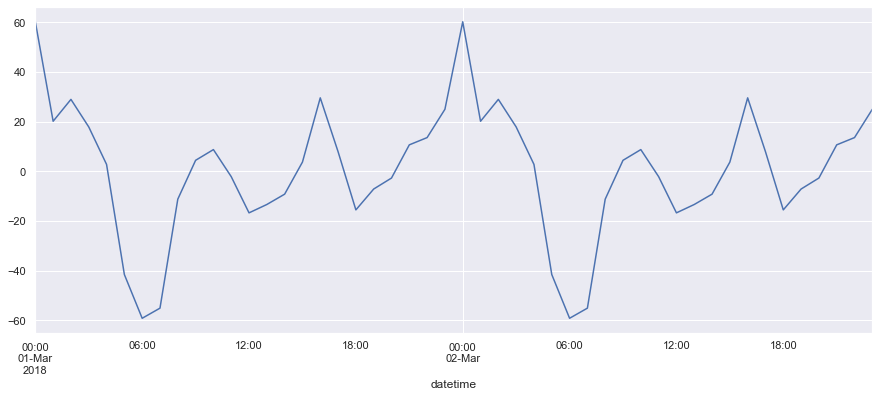

In [91]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15, 6));

Можно выделить 3 периода, когда часто заказывают такси(сезонность) - утром, вечером, а также в полночь, следовательно можно обозначить это модели, чтобы они понимала, что в такое время большой наплыв народа.

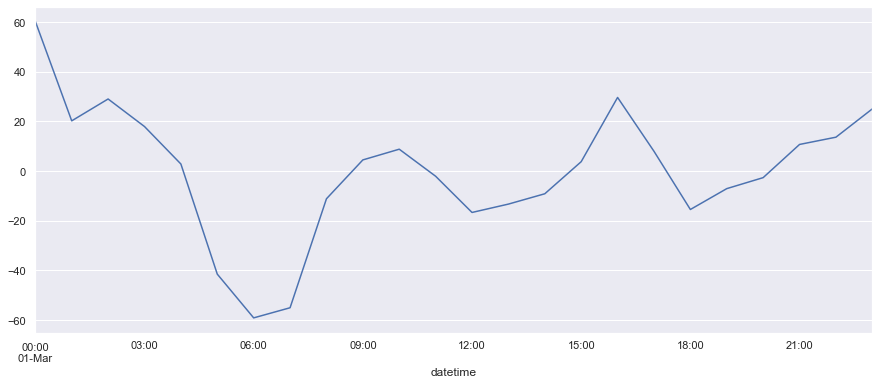

In [92]:
# график ближе
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(figsize=(15, 6));

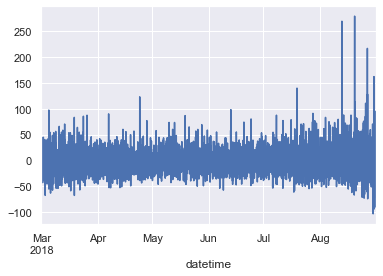

In [93]:
# остатки
decomposed.resid.plot();

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Имеется тренд(восходящий), а также сезенность(3 периода в дне, когда количетсов заказов в час растет). Также видно рост дисперсии, начиная с августа, это повляет на качество тестовой выборки.

## Обучение

In [1]:
def new_features(data, shift, rolling_mean_size):
    new_df = data.copy()
    new_df['month'] = new_df.index.month
    new_df['hour'] = new_df.index.hour
     
    for lag in range(1, shift + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    new_df['diff_rolling_mean'] = new_df['rolling_mean'].diff()
    
    new_df['rolling_median'] = new_df['num_orders'].shift().rolling(rolling_mean_size).median()
    
    new_df['stationary'] = new_df['num_orders'].shift().diff()
    
    return new_df

In [95]:
data = new_features(df_resample, 24, 24)

In [96]:
def orders(df):
    hour = df['hour']
    if hour >= 6 and hour <= 10:
        return 'morning'
    if hour >= 12 and hour <=16:
        return 'lunch'
    if hour >= 18 or hour == 0:
        return 'evening'
    return 'standard'

In [97]:
data['increase_orders'] = data.apply(orders, axis=1)

In [98]:
data['increase_orders'].value_counts()

evening     1288
standard    1288
morning      920
lunch        920
Name: increase_orders, dtype: int64

In [99]:
# косинусо-синосовое преобразование признаков, связанных со временем и  датой
def cos_sin_transformation(data, columns):
    for column in columns:
        data['mnth_sin_' + column] = np.sin((data[column]-1)*(2.*np.pi/12))
        data['mnth_cos_' + column] = np.cos((data[column]-1)*(2.*np.pi/12))
     
    
columns = ['month', 'hour']    
cos_sin_transformation(data, columns)

In [100]:
data.columns

Index(['num_orders', 'month', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean', 'diff_rolling_mean', 'rolling_median', 'stationary',
       'increase_orders', 'mnth_sin_month', 'mnth_cos_month', 'mnth_sin_hour',
       'mnth_cos_hour'],
      dtype='object')

In [101]:
train, test = train_test_split(data, test_size=0.1, random_state=67, shuffle=False)
train = train.dropna()

In [102]:
X_train = train.drop(['num_orders', 'month', 'hour'], axis=1)
X_test = test.drop(['num_orders', 'month', 'hour'], axis=1)

y_train = train['num_orders']
y_test = test['num_orders']

In [103]:
scaler = StandardScaler()
numeric = X_train.drop(['increase_orders'], axis=1).columns
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [104]:
ohe = OneHotEncoder(drop='first')
ohe_df_train = ohe.fit_transform(np.array(X_train['increase_orders']).reshape(-1, 1))
ohe_df_train = pd.DataFrame(ohe_df_train.todense(), columns=ohe.get_feature_names_out(), index = X_train.index)

ohe_df_test = ohe.transform(np.array(X_test['increase_orders']).reshape(-1, 1))
ohe_df_test = pd.DataFrame(ohe_df_test.todense(), columns=ohe.get_feature_names_out(), index = X_test.index)

X_train = X_train[numeric].join(ohe_df_train)

X_test = X_test[numeric].join(ohe_df_test)


### Baseline

Собираюсь использовать линейную модель, рандомные леса, а также LGBM. Есть только некоторые ограничения в деревянных моделях, они не смогут предсказать тренд через какое-то определенное время, т.е. если тренд растет, то деревянные модели в какой-то период не смогут предсказывать значения выше той планки, на которой они обучались.

In [105]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,diff_rolling_mean,rolling_median,stationary,mnth_sin_month,mnth_cos_month,mnth_sin_hour,mnth_cos_hour,x0_lunch,x0_morning,x0_standard
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,0.299600,-0.527416,0.894829,-0.320059,-0.449034,-0.862704,-0.138431,-0.888696,-0.914215,-0.318720,...,-1.085777,-0.890683,0.884077,0.667426,1.665400,-1.285181e-16,1.413677,0.0,0.0,1.0
2018-03-02 02:00:00,1.075147,0.299817,-0.527352,0.895864,-0.319646,-0.448696,-0.863038,-0.138275,-0.888341,-0.914023,...,1.085976,-0.890683,0.828807,0.667426,1.665400,7.071963e-01,1.224232,0.0,0.0,1.0
2018-03-02 03:00:00,-0.088173,1.075348,0.300099,-0.527025,0.896600,-0.319319,-0.448977,-0.862819,-0.137998,-0.888140,...,0.110261,-0.890683,-1.243806,0.667426,1.665400,1.224900e+00,0.706659,0.0,0.0,1.0
2018-03-02 04:00:00,-0.372540,-0.087949,1.075834,0.300838,-0.526667,0.896829,-0.319583,-0.448794,-0.862467,-0.137541,...,-0.078587,-0.890683,-0.304221,0.667426,1.665400,1.414393e+00,-0.000358,0.0,0.0,1.0
2018-03-02 05:00:00,-1.510008,-0.372310,-0.087769,1.076959,0.301416,-0.526323,0.896722,-0.319411,-0.448485,-0.862257,...,-0.739555,-0.890683,-1.216171,0.667426,1.665400,1.224900e+00,-0.707375,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,0.325452,-1.018586,-0.320489,0.119743,1.672928,2.319981,9.281462,5.037040,2.113029,2.761325,...,-0.204486,2.069620,1.436774,-2.274212,-0.819029,-1.224900e+00,-0.707375,0.0,1.0,0.0
2018-08-13 10:00:00,1.514623,0.325668,-1.018651,-0.320059,0.120273,1.673094,2.320058,9.280798,5.036778,2.114256,...,0.897128,2.199458,1.270965,-2.274212,-0.819029,-1.414393e+00,-0.000358,0.0,1.0,0.0
2018-08-13 11:00:00,2.005803,1.514816,0.325957,-1.018568,-0.319646,0.120564,1.673087,2.320000,9.280095,5.039005,...,1.495147,2.329295,0.524824,-2.274212,-0.819029,-1.224900e+00,0.706659,0.0,0.0,1.0


In [106]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

44.9953394386414

Неплохо, глянем результаты RandomForest без нахождения оптимальных гиперпараметров

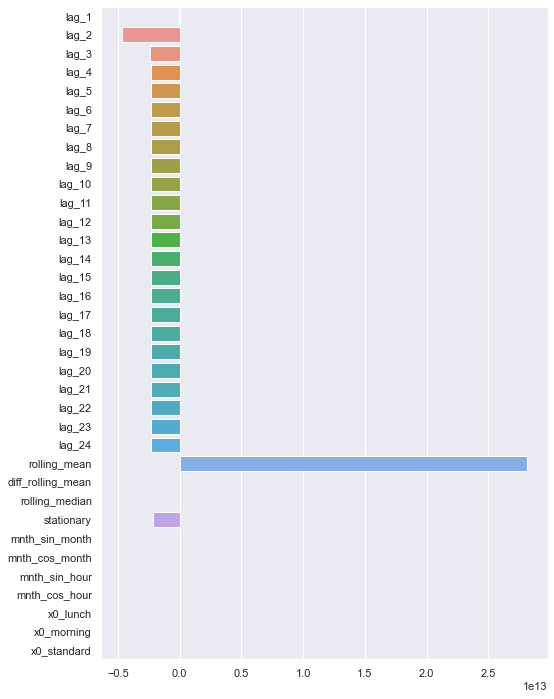

In [107]:
plt.figure(figsize=(8, 12))
sns.barplot(x=lr.coef_, y=X_test.columns);

Все предсказание делается исключительно по скользящему среднему

In [108]:
forest = RandomForestRegressor(n_estimators=100,
                               max_features='sqrt', 
                               max_depth=6,
                               n_jobs = -1,
                               oob_score=True)

forest.fit(X_train, y_train)
pred = forest.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

50.8644189542878

Baseline лучше на линейной модели, глянем, что будет дальше, когда добавится градиентный бустинг.

In [109]:
analys_df = pd.DataFrame(forest.feature_importances_, index = X_train.columns).reset_index()
analys_df.columns = ['features', 'imp']

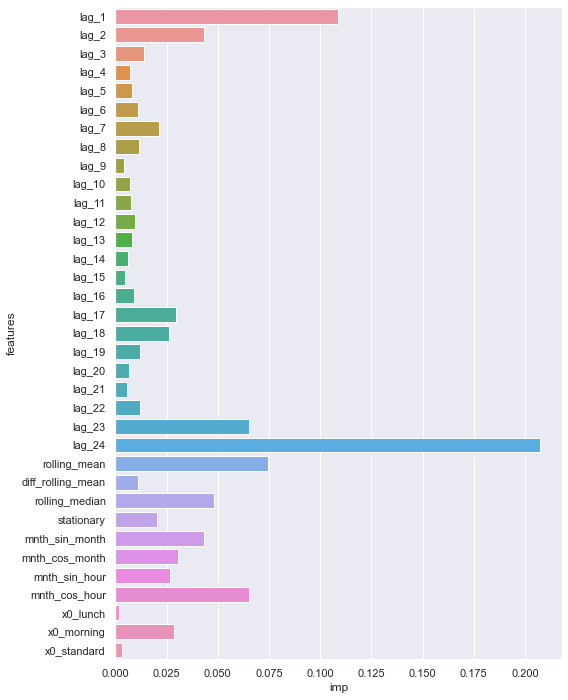

In [110]:
plt.figure(figsize=(8, 12))
sns.barplot(x=analys_df['imp'], y=analys_df['features']);

Деревянная модель делает предсказание по пришлому значению количества заказов(за час и 24 часа до)

Ниже решил попробовать выявить те признаки, которые коррелируют друг с другом, т.е. заменяют друг друга, в итоге хотелось бы удалить их, если таковы имеются

In [111]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

Суть в том, что чем правее от "корня"(корень, это левая часть графика) дерева соединяются пары столбцов, тем более они схожи.

Какова суть, если у нас в правой части есть связь между признаками очень близкой к 0, то эти признакми взаимозаменяют друг друга, следовательно, их можно удалить. Чем дальше от 0, тем эти признаки не коррелируют между собой.

В данном случае у нас есть rolling_mean и rolling_median, которые почти взаимозаменяют друг друга, но не прям критично. Можно попробовать удалить какой-то из них, который менее важен, если результат модели не сильно изменится, то оставить с удаленным признаком.

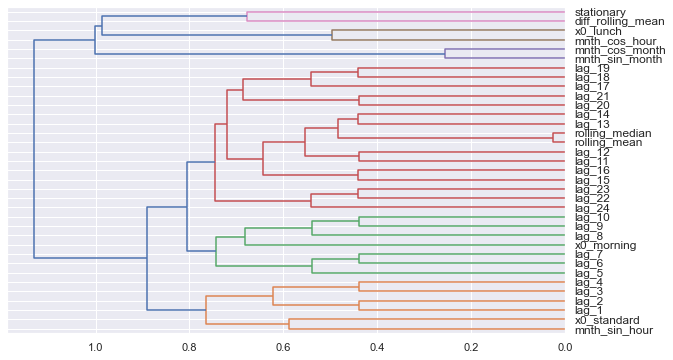

In [112]:
cluster_columns(X_train)

В данном случае видно, что есть некая зависимость у rolling_mean и rolling_median, что логично, но это не сильно критично.

### Улучшение моделей

### RandomForest

In [113]:
time_cv = TimeSeriesSplit(n_splits=10)
parameters = {
    'n_estimators': [100, 200, 400, 800, 1000],
    'max_depth': [4, 8, 12]
}


rfc = RandomForestRegressor(max_features='sqrt')
gs = GridSearchCV(rfc, parameters, cv=time_cv, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(max_features='sqrt'), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12],
                         'n_estimators': [100, 200, 400, 800, 1000]},
             scoring='neg_root_mean_squared_error')

In [114]:
-gs.best_score_, gs.best_params_

(24.174513198823878, {'max_depth': 12, 'n_estimators': 400})

In [115]:
pred = gs.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

44.1379863727048

### LGBM

In [116]:
parameters = {
    'n_estimators': [400, 600],
    'max_depth': [12, 18],
    'learning_rate': [0.01],
    'num_leaves': [12, 24]
}


lgbm = LGBMRegressor()
gs = GridSearchCV(lgbm, parameters, cv=time_cv, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [12, 18],
                         'n_estimators': [400, 600], 'num_leaves': [12, 24]},
             scoring='neg_root_mean_squared_error')

In [117]:
-gs.best_score_, gs.best_params_

(24.07108186208653,
 {'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 600,
  'num_leaves': 24})

In [118]:
pred = gs.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

42.65518494917868

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Были обучены модели: LinearRegression, RandomForest, LightGBM. Лучшая среди них - LightGBM.

## Тестирование

### Догонка гиперпараметров с помощью optuna

In [119]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 17, 19),
        'n_estimators': trial.suggest_int('n_estimators', 560, 640, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 24),
        'learning_rate': [0.01]
    }

    
    # задаём модели требуемые параметры    
    model=LGBMRegressor(**params)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=X_train, y=y_train, 
                            scoring='neg_root_mean_squared_error', cv=time_cv, n_jobs=-1)

    
    return -score.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2022-08-25 14:24:54,983] A new study created in memory with name: no-name-8b945eb3-db17-4a39-b7ff-4b924b34b9a0
[I 2022-08-25 14:24:56,917] Trial 0 finished with value: 24.03679781582115 and parameters: {'max_depth': 18, 'n_estimators': 620, 'num_leaves': 22}. Best is trial 0 with value: 24.03679781582115.
[I 2022-08-25 14:24:58,640] Trial 1 finished with value: 24.050760931920543 and parameters: {'max_depth': 18, 'n_estimators': 580, 'num_leaves': 21}. Best is trial 1 with value: 24.050760931920543.
[I 2022-08-25 14:25:00,184] Trial 2 finished with value: 24.082609319359054 and parameters: {'max_depth': 19, 'n_estimators': 560, 'num_leaves': 20}. Best is trial 2 with value: 24.082609319359054.
[I 2022-08-25 14:25:01,952] Trial 3 finished with value: 24.05758506101572 and parameters: {'max_depth': 18, 'n_estimators': 560, 'num_leaves': 23}. Best is trial 2 with value: 24.082609319359054.
[I 2022-08-25 14:25:03,719] Trial 4 finished with value: 24.054055766861573 and parameters: {'max

In [120]:
study.best_params, study.best_value

({'max_depth': 17, 'n_estimators': 560, 'num_leaves': 24}, 24.086694485555643)

In [121]:
%%time
lgbm_basic = LGBMRegressor(learning_rate=0.01,
                     max_depth=17,
                     n_estimators=560,
                     num_leaves=24)

lgbm_basic.fit(X_train, y_train)
pred = lgbm_basic.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

Wall time: 543 ms


42.69812859903616

Хотелось бы понять, какие столцбы нам не нужны, т.е. у нас как бы распределение должно быть одинаковым в тренировочной и тестовой выборке, но может быть такое, что это совсем не так, т.к. какие-то столбцы делают их отличными. Ниже постараюсь это выяснить. 

Постараемся спрогнозировать, находится ли строка в тренировочной или тестовой выборке. Для этого совмещаем тестовую и трейновую выборки, создаем зависимую переменную, которая покажет нам, в какой выборке эта строка и строим таблицу важности признаков, которая отражает нам важность столбца, т.е. столбцы с высокой важностью могут влиять на распределение.


In [122]:
full_test = pd.concat([X_train, X_test])
full_target = np.array([0]*len(X_train) + [1]*len(X_test))

In [124]:
lgbm = LGBMRegressor(learning_rate=0.01,
                     max_depth=17,
                     n_estimators=560,
                     num_leaves=24)

lgbm.fit(full_test, full_target)

LGBMRegressor(learning_rate=0.01, max_depth=17, n_estimators=560, num_leaves=24)

In [125]:
future_df = pd.DataFrame(lgbm.feature_importances_, index = full_test.columns).reset_index()
future_df.columns = ['features', 'imp']
future_df.sort_values('imp', ascending=False)

,features,imp
26,rolling_median,2571
24,rolling_mean,2239
28,mnth_sin_month,503
11,lag_12,454
15,lag_16,453
4,lag_5,353
0,lag_1,350
8,lag_9,348
10,lag_11,347
5,lag_6,337


Не влияют на деление нижние признаки. Видно, что влияют первые 2 признака: rolling_median и rolling_mean

In [127]:
print('Изначальный rmse', mean_squared_error(y_test, pred, squared=False))

for column in np.array(future_df.sort_values('imp', ascending=False)['features'])[:2]:
    model = LGBMRegressor(learning_rate=0.01,
                          max_depth=17,
                          n_estimators=560,
                          num_leaves=24)

    model.fit(X_train.drop(column, axis=1), y_train)
    
    print(column, mean_squared_error(y_test, model.predict(X_test.drop(column, axis=1)), squared=False))

Изначальный rmse 42.69812859903616
rolling_median 42.24025068186276
rolling_mean 42.67435937910173


Без этих признаков становится чуть лучше, удалим их, обучим модель заново, чтобы посмотреть, останется ли результат в районе того, каким был

In [128]:
column_drop = ['rolling_mean', 'rolling_median']

In [134]:
def find_best_features(x_train, y_train, x_test, y_test):
    model = LGBMRegressor(learning_rate=0.01,
                          max_depth=17,
                          n_estimators=560,
                          num_leaves=20)

    model.fit(x_train, y_train)
    print('RMSE cv',-cross_val_score(model, x_train, y_train, scoring='neg_root_mean_squared_error', cv=time_cv).mean())


    pred = model.predict(x_test)
    print('RMSE test', mean_squared_error(y_test, pred, squared=False))

In [135]:
# до
find_best_features(X_train, y_train, X_test, y_test)

RMSE cv 24.082609319359054
RMSE test 42.421103009301035


In [136]:
# после
find_best_features(X_train.drop(column_drop, axis=1), y_train, X_test.drop(column_drop, axis=1), y_test)

RMSE cv 24.044916724986706
RMSE test 42.80676470151387


Модель не стала сильно хуже, следовательно, эти признаки сильно не повлияли, можно оставить без них.

In [137]:
X_train_drop = X_train.drop(column_drop, axis=1)
X_test_drop = X_test.drop(column_drop, axis=1)

In [138]:
%%time
lgbm_basic = LGBMRegressor(learning_rate=0.01,
                     max_depth=17,
                     n_estimators=560,
                     num_leaves=24)

lgbm_basic.fit(X_train_drop, y_train)
pred = lgbm_basic.predict(X_test_drop)
mean_squared_error(y_test, pred, squared=False)

Wall time: 584 ms


42.412924329503554

---

### Catboost

In [139]:
# Произвожу кросс-валидацию
params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 1000
#params['custom_loss'] = 'AUC'
params['random_seed'] = 67
params['learning_rate'] = 0.01

cv_data = cv(
    params = params,
    pool = Pool(X_train, label=y_train),
    fold_count=10,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]



bestTest = 33.55057851
bestIteration = 998

Training on fold [1/10]



bestTest = 23.3338363
bestIteration = 994

Training on fold [2/10]



bestTest = 22.55579946
bestIteration = 999

Training on fold [3/10]



bestTest = 21.51250065
bestIteration = 999

Training on fold [4/10]



bestTest = 19.74942229
bestIteration = 997

Training on fold [5/10]



bestTest = 21.27541152
bestIteration = 998

Training on fold [6/10]



bestTest = 20.78975622
bestIteration = 998

Training on fold [7/10]



bestTest = 21.21148873
bestIteration = 999

Training on fold [8/10]



bestTest = 19.68942001
bestIteration = 988

Training on fold [9/10]



bestTest = 19.49688222
bestIteration = 292



In [140]:
cv_data['test-RMSE-mean'].mean()

27.61222162397277

In [141]:
model = CatBoostRegressor(
    iterations=990,
    learning_rate=0.01,
    random_seed=67,
    #custom_loss='RMSE',
    use_best_model=True)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [142]:
pred = model.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

44.16227699340217

Хуже, чем у LGBM, следовательно, выбираю LGBM

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Обучил CatBoost для сравнения, он оказался хуже. Нашёл лучшие гиперпараметры для LightGBM, а также удалил некие фичи для улучшения модели.

## Выводы

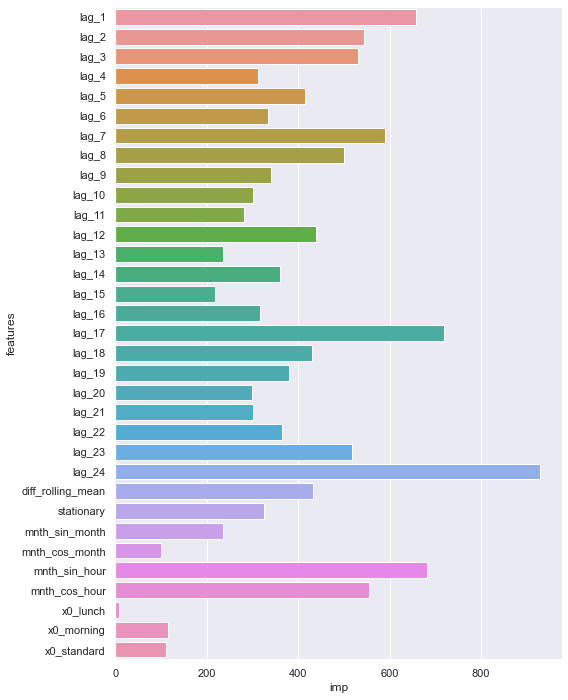

In [143]:
analys_df_lgbm = pd.DataFrame(lgbm_basic.feature_importances_, index = X_train_drop.columns).reset_index()
analys_df_lgbm.columns = ['features', 'imp']
plt.figure(figsize=(8, 12))
sns.barplot(x=analys_df_lgbm['imp'], y=analys_df_lgbm['features']);

Если глянуть график важности признаков, то видно, что самые важные признаки - час, lag_1, lag_17, lag_24, mnth_sin_hour, mnth_cos_hour

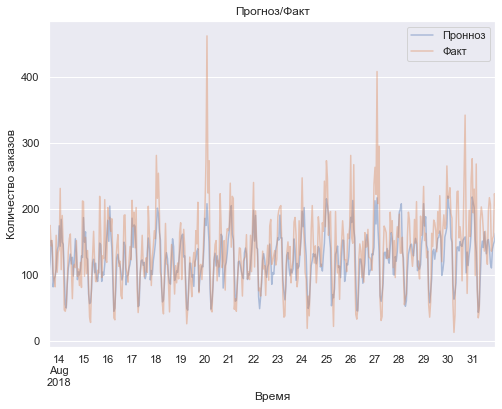

In [144]:
pred = lgbm_basic.predict(X_test_drop)
plt.figure(figsize=(8, 6))
pd.Series(pred, index=y_test.index).plot(alpha=0.4)
y_test.plot(alpha=0.4);
plt.xlabel('Время');
plt.ylabel('Количество заказов');
plt.title('Прогноз/Факт');
plt.legend(['Пронноз', 'Факт']);

Модель плохо предсказывает высокое количество заказов. А в остальном все хорошо.

### Shap(LGBM)

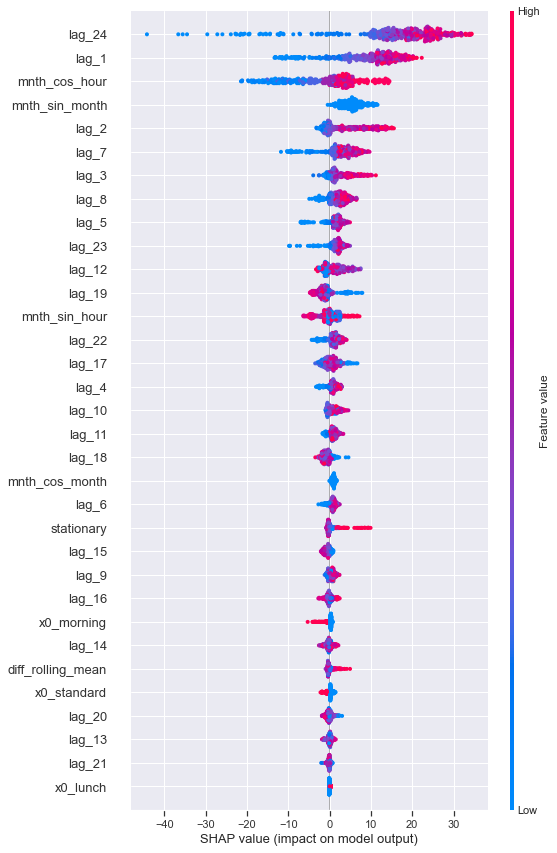

In [145]:
shap_values = shap.TreeExplainer(lgbm_basic).shap_values(X_test_drop)
shap.summary_plot(shap_values, X_test_drop, max_display=83)

Какие выводы можно сделать: чем меньше больше прошлое количество заказов, тем больше будет в след. часу и наоборот; чем выше прошлое количество заказок за 24 часа, тем выше будет заказов в след. часу; чем больше время, тем выше количество заказов. Это из тех выводов, которые явно видно, остальные не так сильно выражены.

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Исходя из работы над проектом были выявылены тренд и сезонность. Разработана модель, которая может предсказывать будущее, но не слишком далекое. Среди всех моделей, которые были обучены, выбрана LightGBM, которая дала результа RMSE = 42. Выявлены некоторые зависимости: чем меньше больше прошлое количество заказов, тем больше будет в след. часу и наоборот; чем выше прошлое количество заказок за 24 часа, тем выше будет заказов в след. часу; чем больше время, тем выше количество заказов. Это из тех выводов, которые явно видно, остальные не так сильно выражены.